# Problema 2: Optimización Multiobjetivo en Planificación de Rutas de Inspección

## 1. Formulación del Modelo Multiobjetivo

### 1.1. Conjuntos
- $V = \{0, 1, 2, 3, \dots\}$ : Lista de nodos/localidades.
- $K = \{0, 1\}$ : Conjunto de vendedores.

### 1.2. Indices
- $i \in V$ : Nodo de origen.
- $j \in V$ : Nodo de destino.
- $k \in K$ : Índice de vendedor.

### 1.3. Parámetros
- graph: Grafo de pesos (matriz de costos entre nodos).
- ciudades: Número total de nodos.
- calidad: Es el nivel e calidad de inspección que se puede lograr en cada localidad. Por ejemplo, cada elemento $calidad_{i}$ indica la calidad del nodo $i$.
- riesgo: Indica el nivel de riesgo asociado a cada tramo de ruta. Por ejemplo,  Cada elemento $riesgo_{ij}$ indica el nivel de riesgo entre el nodo $i$ y el nodo $j$.

### 1.4. Variables de decisión
- $x_{ijk}$ binaria, que indica si el vendedor $k$ viaja de la ciudad $i$ a la ciudad $j$.
- $u_{ik}$ entera no negativa, que representa el orden en que el vendedor $k$ visita la ciudad $i$.

### 1.5. Funciones objetivo

#### Minimizar Z1 = Distancia total recorrida

Minimizar el número total de trayectos realizados por los vendedores:
$$
\min \sum_{i \in V} \sum_{j \in V} \sum_{k \in K} x_{ijk}
$$
#### Maximizar Z2 = Calidad de inspección acumulad

Maximizar la calidad de las inspecciones
$$
\max \sum_{i \in V} \sum_{j \in V} \sum_{k \in K} x_{ijk} * calidad_{i}
$$

#### Minimizar Z3 = Nivel de riesgo de la ruta

Minimizar el nivel de riesgo asociado a las rutas
$$
\min \sum_{i \in V} \sum_{j \in V} \sum_{k \in K} x_{ijk} * riesgo_{ij}
$$

### 1.6. Restricciones

#### 1. Cada ciudad se visita una vez
$$
\sum_{\substack{i \in V \\ i \ne j}} \sum_{k \in K} x_{ijk} = 1 \quad \forall j \in V \setminus \{0\}
$$

#### 2. Se sale del nodo base ($0$) una vez por vendedor
$$
\sum_{\substack{j \in V \\ j \ne 0}} x_{0jk} = 1 \quad \forall k \in K
$$

#### 3. Se retorna al nodo base ($0$) una vez por vendedor
$$
\sum_{\substack{i \in V \\ i \ne 0}} x_{i0k} = 1 \quad \forall k \in K
$$

#### 4. Flujo: cada vendedor sale de los nodos a los que entra
$$
\sum_{\substack{i \in V \\ i \ne j}} x_{ijk} = \sum_{\substack{i \in V \\ i \ne j}} x_{jik} \quad \forall j \in V \setminus \{0\}, \forall k \in K
$$

#### 5. Eliminación de subtours (formulación MTZ)
$$
u_{ik} - u_{jk} + \text{ciudades} \cdot x_{ijk} \leq \text{ciudades} - 1 \quad \forall k \in K, \forall i \in V \setminus \{0\}, \forall j \in V \setminus \{0\}
$$



## 2. Selección y Justificación del Método de Resolución:
- Elija un método multiobjetivo (Suma ponderada, ϵ-constraint o lexicográfico)
para resolver el problema planteado.

- Justifique claramente la elección del método seleccionado según las características del problema y los objetivos considerados.

## 3. Implementación

{0: 100, 1: 15, 2: 8, 3: 22, 4: 10, 5: 18, 6: 12, 7: 5, 8: 25, 9: 16}
Deleting model components (O_z).
Deleting model components (res1_index, res1).
Deleting model components (res2_index, res2).
Deleting model components (res3_index, res3).
Deleting model components (res4_index, res4).
Deleting model components (res5_index, res5).
Deleting model components (O_z).
Deleting model components (res1_index, res1).
Deleting model components (res2_index, res2).
Deleting model components (res3_index, res3).
Deleting model components (res4_index, res4).
Deleting model components (res5_index, res5).
Deleting model components (O_z).
Deleting model components (res1_index, res1).
Deleting model components (res2_index, res2).
Deleting model components (res3_index, res3).
Deleting model components (res4_index, res4).
Deleting model components (res5_index, res5).
Deleting model components (O_z).
Deleting model components (res1_index, res1).
Deleting model components (res2_index, res2).
Deleting model c

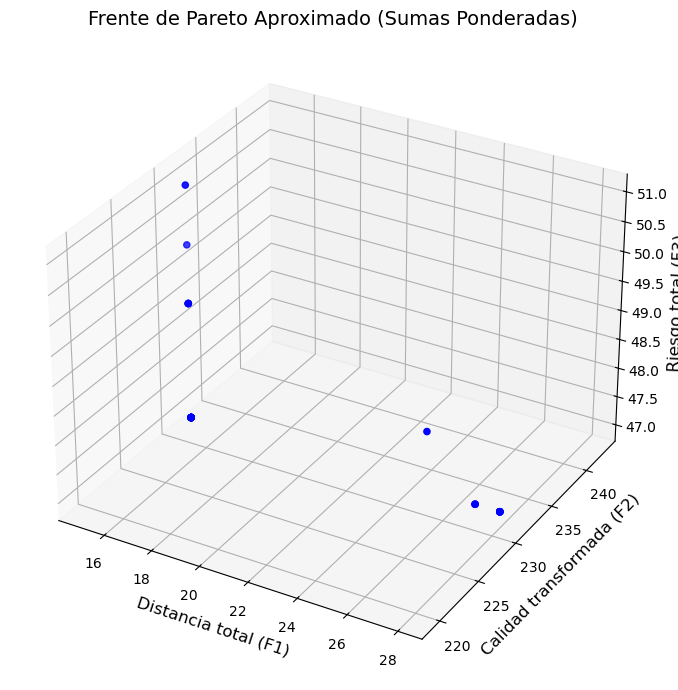

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.opt import SolverFactory
import numpy as np
import networkx as nx
import random
from scipy.spatial import Delaunay

#FUNCION ELIMINAR COMPONENTE
def delete_component(Model, comp_name):

        list_del = [vr for vr in vars(Model)
                    if comp_name == vr
                    or vr.startswith(comp_name + '_index')
                    or vr.startswith(comp_name + '_domain')]

        list_del_str = ', '.join(list_del)
        print('Deleting model components ({}).'.format(list_del_str))

        for kk in list_del:
            Model.del_component(kk)


#MODELO

#Configuracion Iteraciones----------------------------------------------------
numIteraciones = 11
w_vec = []
for i in range(numIteraciones):
    for j in range(numIteraciones - i):
        w1 = i / (numIteraciones - 1)
        w2 = j / (numIteraciones - 1)
        w3 = 1 - w1 - w2
        if w3 >= 0:
            w_vec.append((w1, w2, w3))    
#Creación Modelo--------------------------------------------------------------
Model = ConcreteModel()

#sets & parameters------------------------------------------------------------

ciudades = 10
spread = 1.5
vendedores = 1
nodos = [_ for _ in range(ciudades)]
cota = 100

# Cargar datos del csv
filename = "cost_matrix_" + str(ciudades) + "_nodes_" + str(spread) + "_spread.csv"

data = np.loadtxt(filename, delimiter=",", dtype=int)
nodos = list(map(int, data[0]))

graph = {
    (i, j): data[r + 1, c] for r, i in enumerate(nodos) for c, j in enumerate(nodos)
}

V = {_ for _ in nodos}
A = {(i, j) for i in nodos for j in nodos if i != j}
K = {_ for _ in range(vendedores)}

#calidad -----------------------------------------------------------------------
calidad = {
    0: 0,
    1: 85,
    2: 92,
    3: 78,
    4: 90,
    5: 82,
    6: 88,
    7: 95,
    8: 75,
    9: 84
}

#modificar calidad para minimizar

for i in calidad.keys():
    calidad[i] = cota - calidad[i]
print(calidad)
#calidad = {i: 100 - calidad[i] for i in calidad.keys()}


#riesgos -----------------------------------------------------------------------

riesgos = {}

nodos = range(10)

riesgo_dados = {
    (0, 1): 3,
    (0, 2): 2,
    (0, 3): 4,
    (0, 4): 5,
    (0, 5): 6,
    (0, 6): 3,
    (0, 7): 2,
    (0, 8): 4,
    (0, 9): 5,
    (2, 8): 9,
    (2, 9): 8,
    (3, 4): 5,
    (4, 9): 7,
    (5, 6): 7,
    (8, 9): 7
}

for (i, j), val in riesgo_dados.items():
    if (j, i) not in riesgos:
        riesgos[(i, j)] = val

for i in nodos:
    for j in nodos:
        if i < j and (i, j) not in riesgos:
            riesgos[(i, j)] = 5
            
#variables--------------------------------------------------------------------

Model.x = Var(A, K, within=Binary)
Model.u = Var(V, K, within=NonNegativeIntegers, bounds=(1, ciudades - 1))


# # OBJECTIVE FUNCTIONS*************************************************************

#Función distiancia mínima
Model.f1 = sum(graph[i, j] * Model.x[i, j, k] for i, j in A for k in K)

#Función calidad
Model.f2 = sum(calidad[j] * Model.x[i, j, k] for i, j in A for k in K)

#Función riesgo
Model.f3 = sum( riesgos.get((i,j),5) * Model.x[i, j, k] for i, j in A for k in K)


#Proceso para ejecutar varias veces el modelo matemático con el fin de aplicar el
#m todo de Smas Ponderadas.
f1_vec=[]
f2_vec=[]
f3_vec=[]
for w1,w2,w3 in w_vec:

    #Funci n objetivo general
    Model.O_z = Objective(expr= w1*Model.f1 + w2*Model.f2 + w3*Model.f3 , sense=minimize)

    # Cada ciudad de los tours es visitada una vez
    Model.res1 = ConstraintList()
    for j in nodos[1:]:  # Excluir la ciudad 0
        Model.res1.add(sum(Model.x[i, j, k] for i in nodos if i != j for k in K) == 1)

    # Se sale de 0 una vez
    Model.res2 = ConstraintList()
    for k in K:
        Model.res2.add(sum(Model.x[0, j, k] for j in nodos[1:]) == 1)

    # Se retorna a 0 una vez
    Model.res3 = ConstraintList()
    for k in K:
        Model.res3.add(sum(Model.x[i, 0, k] for i in nodos[1:]) == 1)

    # Cada vendedor que llega a una ciudad debe salir de ella
    Model.res4 = ConstraintList()
    for j in nodos[1:]:  # Excluir la ciudad 0
        for k in K:
            Model.res4.add(
                sum(Model.x[i, j, k] for i in nodos if i != j)
                == sum(Model.x[j, i, k] for i in nodos if i != j)
            )

    # Eliminación de subtours mtz
    Model.res5 = ConstraintList()
    for k in K:
        for i in nodos[1:]:  # Excluir la ciudad 0
            for j in nodos[1:]:  # Excluir la ciudad 0
                if i != j:
                    Model.res5.add(
                        Model.u[i, k] - Model.u[j, k] + ciudades * Model.x[i, j, k]
                        <= ciudades - 1
                    )


    SolverFactory('glpk').solve(Model)
    
    # Corrected calculation of f2_real
    #f2_real = sum(Model.x[i, j, k].value * (cota - calidad[j]) for i, j in A for k in K)
    
    valorF1=value(Model.f1)
    valorF2=value(Model.f2)
    valorF3=value(Model.f3)
    
    f1_vec.append(valorF1)
    f2_vec.append(valorF2)
    f3_vec.append(valorF3)
    
    delete_component(Model, 'O_z')
    delete_component(Model, 'res1')
    delete_component(Model, 'res2')
    delete_component(Model, 'res3')
    delete_component(Model, 'res4')
    delete_component(Model, 'res5')

    #end for
print(w_vec)
print(f1_vec)
print  (f2_vec)
print(f3_vec)

# Graficar frente de Pareto en 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(f1_vec, f2_vec, f3_vec, c='b', marker='o')

ax.set_title('Frente de Pareto Aproximado (Sumas Ponderadas)', fontsize=14)
ax.set_xlabel('Distancia total (F1)', fontsize=12)
ax.set_ylabel('Calidad transformada (F2)', fontsize=12)
ax.set_zlabel('Riesgo total (F3)', fontsize=12)

plt.tight_layout()
plt.show()
